In [146]:
import xgboost
import pandas as pd
import numpy as np
import optuna
import shap
import pickle
import os
import warnings
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import TimeSeriesSplit as tss
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn import tree

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# pandasの表示を設定
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 50

In [147]:
df = pd.read_csv('train_merged.csv')
target = 'is_congestion_tomorrow'
ignore_features = ['datetime', 'end_code', 'start_code']

df['datetime'] = pd.to_datetime(df['datetime'])

df_train = df[df['datetime'] < dt.datetime(2023, 7, 1)]
df_test = df[df['datetime'] >= dt.datetime(2023, 7, 1)]

In [148]:
def objective(trial):

    params = {
        'eval_metric':'logloss',
        'min_child_weight':trial.suggest_int('min_child_weight',1,5),
        'gamma':trial.suggest_uniform('gamma',0,1),
        'subsample':trial.suggest_uniform('subsample',0,1),
        'colsample_bytree':trial.suggest_uniform('colsample_bytree',0,1),
        'reg_alpha':trial.suggest_loguniform('reg_alpha',1e-5,100),
        'reg_lambda':trial.suggest_loguniform('reg_lambda',1e-5,100),        
        'learning_rate':trial.suggest_uniform('learning_rate',0,1),
        'random_state':123}

    model = XGBClassifier(**params)
    model.fit(train_x, train_y, sample_weight=weight_train)

    pred = model.predict_proba(val_x)
    answer = val_y

    logloss = log_loss(answer, pred)
    return logloss

In [149]:
def find_optimal_threshold(answer, prob_scores):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0
    best_score = 0

    for threshold in thresholds:
        prediction = (prob_scores > threshold).astype(int)
        score = f1_score(answer, prediction)

        if score > best_score:
            best_score = score
            best_threshold = threshold

    return best_score, best_threshold

In [150]:
df_train['datetime'] = pd.to_datetime(df_train['datetime'])

folds = tss(n_splits=5)

test_x = df_test.drop([target, *ignore_features], axis=1)
test_y = df_test[target]

xgb_models = []
predictions = []
weights = []

for fold, (train_index, val_index) in enumerate(folds.split(df_train)):
    
    train, val = df_train.iloc[train_index], df_train.iloc[val_index]
    
    train_y = train[target]
    train_x = train.drop([target, *ignore_features], axis=1)
    val_y = val[target]
    val_x = val.drop([target, *ignore_features], axis=1)
    
    # sample_weightに入れる重みを計算
    weight_train = compute_sample_weight(class_weight='balanced', y=train[target])

    coef_0 = 0.9
    coef_1 = 0.016

    weight_df = pd.DataFrame()
    weight_df['is_congestion_tomorrow'] = train['is_congestion_tomorrow']
    weight_df['weight'] = weight_train
    weight_df.loc[weight_df['is_congestion_tomorrow'] == 0, 'weight'] = (weight_df[weight_df['is_congestion_tomorrow'] == 0]['weight'] * coef_0).set_axis(weight_df.loc[weight_df['is_congestion_tomorrow'] == 0].index)
    weight_df.loc[weight_df['is_congestion_tomorrow'] == 1, 'weight'] = (weight_df[weight_df['is_congestion_tomorrow'] == 1]['weight'] * coef_1).set_axis(weight_df.loc[weight_df['is_congestion_tomorrow'] == 1].index)
    weight_train = weight_df['weight']
    
    # optunaでパラメーター探索
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=123))
    study.optimize(objective, timeout=60)
    
    xgb_model = xgboost.XGBClassifier(**study.best_params)
    xgb_model.fit(train_x, train_y, sample_weight=weight_train)
    
    xgb_models.append(xgb_model)
    
    predict = xgb_model.predict_proba(test_x)
    predict = predict[:, 1]
    
    answer = test_y
    best_threshold = find_optimal_threshold(answer, predict)[1]
    best_predict = (predict > best_threshold).astype(int)
    
    predictions.append(best_predict)
    
    accuracy = accuracy_score(answer, best_predict)
    recall = recall_score(answer, best_predict)
    precision = precision_score(answer, best_predict)
    f1 = f1_score(answer, best_predict)
    
    weights.append(f1)

    print(f'Fold {fold}:')
    print('TN  FP\nFN  TP')
    print(confusion_matrix(answer, best_predict))
    print(f'Accuracy: {accuracy}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}')
    print(f'F1 score : {f1}')
    print('---------------------------------------------\n')

Fold 0:
TN  FP
FN  TP
[[204301    791]
 [   448    380]]
Accuracy: 0.9939831002331002
Recall: 0.45893719806763283
Precision: 0.32450896669513235
F1 score : 0.3801900950475237
---------------------------------------------

Fold 1:
TN  FP
FN  TP
[[204625    467]
 [   500    328]]
Accuracy: 0.9953040015540016
Recall: 0.3961352657004831
Precision: 0.4125786163522013
F1 score : 0.40418977202711026
---------------------------------------------

Fold 2:
TN  FP
FN  TP
[[204620    472]
 [   579    249]]
Accuracy: 0.9948960761460761
Recall: 0.3007246376811594
Precision: 0.34535367545076284
F1 score : 0.32149774047772756
---------------------------------------------

Fold 3:
TN  FP
FN  TP
[[204245    847]
 [   529    299]]
Accuracy: 0.9933177933177934
Recall: 0.3611111111111111
Precision: 0.26090750436300175
F1 score : 0.3029381965552178
---------------------------------------------

Fold 4:
TN  FP
FN  TP
[[204524    568]
 [   501    327]]
Accuracy: 0.9948086635586636
Recall: 0.39492753623188404


In [151]:
majority_predictions = []

for i in range(len(predictions[0])):
    preds = [pred[i] for pred in predictions]
    mode = Counter(preds).most_common(1)[0][0]
    majority_predictions.append(mode)

In [152]:
answer = test_y

accuracy = accuracy_score(answer, majority_predictions)
recall = recall_score(answer, majority_predictions)
precision = precision_score(answer, majority_predictions)
f1 = f1_score(answer, majority_predictions)

print('Voting:')
print('TN  FP\nFN  TP')
print(confusion_matrix(answer, majority_predictions))
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 score : {f1}')

Voting:
TN  FP
FN  TP
[[204651    441]
 [   519    309]]
Accuracy: 0.9953379953379954
Recall: 0.37318840579710144
Precision: 0.412
F1 score : 0.3916349809885931


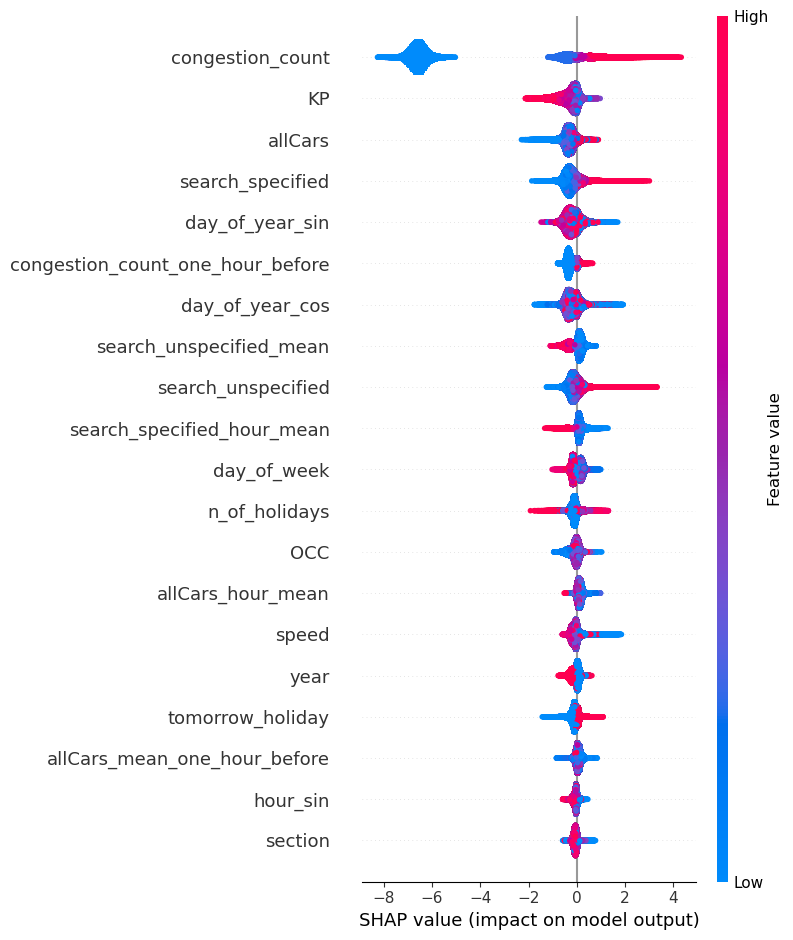

In [153]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(val_x.reset_index(drop=True))

shap.summary_plot(shap_values, val_x, show=False)
plt.show()

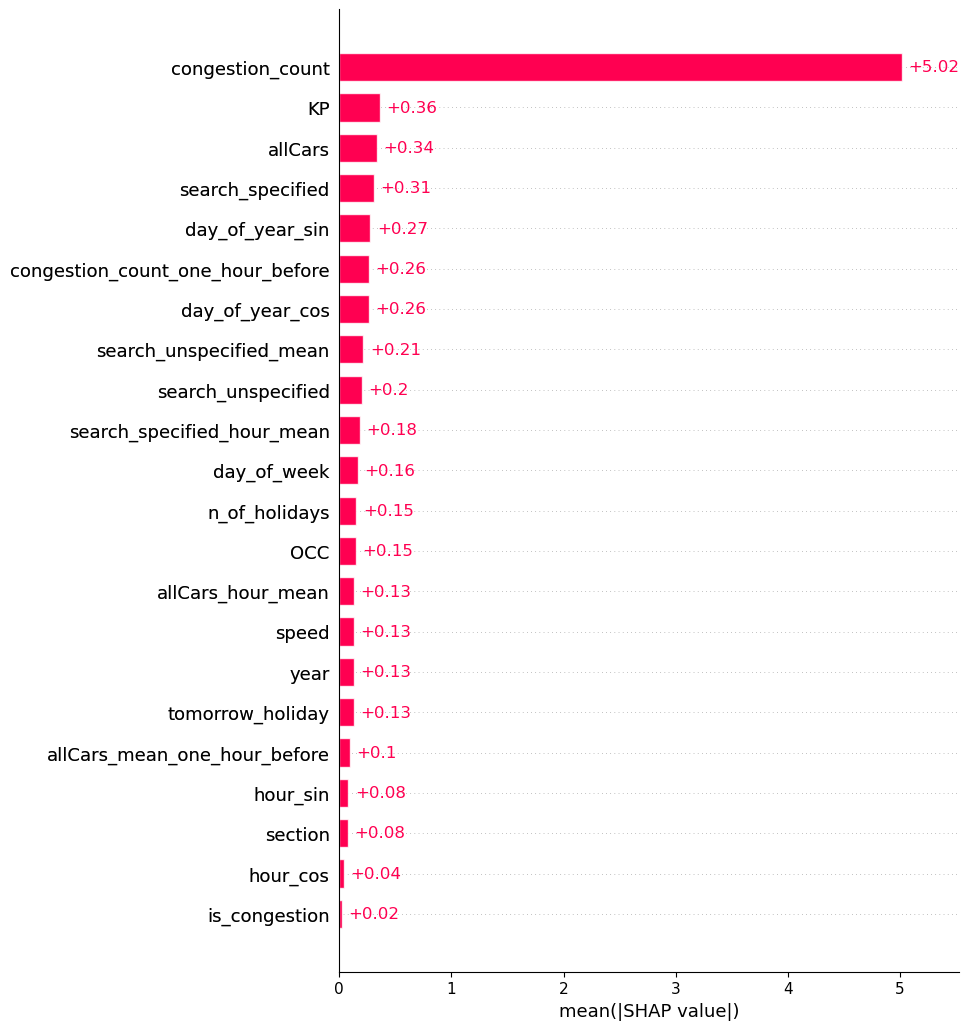

In [154]:
shap.plots.bar(shap_values, max_display=40)
plt.show()

In [155]:
df['datetime'] = pd.to_datetime(df['datetime'])

folds = tss(n_splits=5)

xgb_models = []
predictions = []

for fold, (train_index, val_index) in enumerate(folds.split(df)):
    
    train, val = df.iloc[train_index], df.iloc[val_index]
    
    train_y = train[target]
    train_x = train.drop([target, *ignore_features], axis=1)
    val_y = val[target]
    val_x = val.drop([target, *ignore_features], axis=1)
    
    # sample_weightに入れる重みを計算
    weight_train = compute_sample_weight(class_weight='balanced', y=train[target])

    coef_0 = 0.9
    coef_1 = 0.016

    weight_df = pd.DataFrame()
    weight_df['is_congestion_tomorrow'] = train['is_congestion_tomorrow']
    weight_df['weight'] = weight_train
    weight_df.loc[weight_df['is_congestion_tomorrow'] == 0, 'weight'] = (weight_df[weight_df['is_congestion_tomorrow'] == 0]['weight'] * coef_0).set_axis(weight_df.loc[weight_df['is_congestion_tomorrow'] == 0].index)
    weight_df.loc[weight_df['is_congestion_tomorrow'] == 1, 'weight'] = (weight_df[weight_df['is_congestion_tomorrow'] == 1]['weight'] * coef_1).set_axis(weight_df.loc[weight_df['is_congestion_tomorrow'] == 1].index)
    weight_train = weight_df['weight']
    
    # optunaでパラメーター探索
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=123))
    study.optimize(objective, timeout=60)
    
    xgb_model = xgboost.XGBClassifier(**study.best_params)
    xgb_model.fit(train_x, train_y, sample_weight=weight_train)
    
    xgb_models.append(xgb_model)

In [156]:
model_names = {
    0: "model_fold_0",
    1: "model_fold_1",
    2: "model_fold_2",
    3: "model_fold_3",
    4: "model_fold_4",}

save_dir = "models/"
os.makedirs(save_dir, exist_ok=True)

for fold, xgb_model in enumerate(xgb_models):
    model_name = model_names.get(fold, f'model_fold_{fold}')
    with open(os.path.join(save_dir, f'{model_name}.pkl'), 'wb') as f:
        pickle.dump(xgb_model, f)

In [157]:
#shap.decision_plot(explainer.expected_value, explainer.shap_values(val_x), val_x, show=False, ignore_warnings=True)
#plt.show()